In [14]:
import numpy as np
import pandas as pd
import copy

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

In [15]:
def zs_data(start: str, end: str, src: str) -> pd.DataFrame:
    """Process zone substation data, including resampling to 5 min"""
    data_df = pd.read_csv(src, index_col=0)

    freq='15min'
    intervals_per_hour = 4
  
    # NOTE timestamps indicate start of an interval
    # Starting with 15 min data we'll set the time index to start at the beninning of this 
    # period and then trim off the first 5 min after ffill()
    tmp = pd.date_range(start=pd.to_datetime("2021-7-1 00:00").tz_localize("UTC"), 
                        end=pd.to_datetime("2023-06-30 23:45").tz_localize("UTC"), 
                        freq=freq)
    data_df.index = tmp

    new_df = data_df.loc[start:end]

    return new_df, intervals_per_hour

In [16]:
# Load zone substation data
zs_df, intervals_per_hour = zs_data("2022-1-1 00:00", "2022-12-31 23:45",
    src = "data/evoenergy-zone-substation-report-2021-23.csv")

# Load population data, in various spatial resolutions
pop_SA3_df = pd.read_csv('data/SA3_population.csv', index_col=0)
pop_SA2_df = pd.read_csv('data/SA2_population.csv', index_col=0)
evo_cust_df = pd.read_csv('data/evo_customers.csv', index_col=0)

# Mean temperature data for Canberra from BOM
mean_temps = [20.495001,20.325001,17.85,13.48,9.469999,6.67,5.585,7.105,9.710001,12.985,15.895,18.775]

# Load the NextGen data for household load and solar profiles
# Available from https://zenodo.org/records/14885589
NextGen_solar = pd.read_csv('data/NextGen_solar.csv', index_col=0) 
NextGen_solar_normalised = NextGen_solar/NextGen_solar.min()
NextGen_solar_normalised.index = zs_df.index

# Map population data to zone substations
SA3_dict = {'Gungahlin':['Gold Creek'],
            'Tuggeranong':['Wanniassa', 'Gilmore', 'Theodore'],
            'Woden Valley':['Woden', 'Wanniassa'],
            'Canberra East':['East Lake'],
            'South Canberra':['Telopea Park'],
            'Belconnen':['Belconnen', 'Latham'],
            'North Canberra':['Civic', 'City East'],
            'Weston Creek':['Woden'],
            'Molonglo':['Woden'],
            'Urriarra - Namadgi':['Tennent/Angle Crossing'],}
SA3_division = {'Woden Valley':[39238/(39238+24315+12102), 39238/(39238+88965)],
                'Tuggeranong':[88965/(39238+88965), 1, 1],
            'Weston Creek':[24315/(39238+24315+12102), ],
            'Molonglo':[12102/(39238+24315+12102)],
            'Gungahlin':[1],
            'Canberra East':[1,1],
            'South Canberra':[1],
            'Belconnen':[1,1],
            'North Canberra':[1,1]}

# Zone substation ratings from evoenergy annual report
# Table 54  [Continuous, 2hr emergency] ratings
zs_ratings = {'Gold Creek':[57,74], 
             'Gilmore':[45,62],  
             'Theodore':[45,62], 
            'Woden':[95,95], 
            'East Lake':[50,60], 
            'Fyshwick':[28,28], 
            'Telopea Park':[100,114], 
            'Belconnen':[55,74], 
            'Latham':[95,95], 
            'Civic':[110,114],
            'City East':[95,95],
            'Wanniassa':[95,95]} 
zs_total = [870,968]

# ACT population 2023
ACT_pop_total_current = 457565
# MW of ACT solar capacity as of 30/6/2024 from APVI 
ACT_solar_current = 448

# ACT vehicle registrations
# 2021 data https://www.abs.gov.au/statistics/industry/tourism-and-transport/motor-vehicle-census-australia/latest-release
ACT_vehicles = 318000 
# Assume per capita vehicle registrations remain constant at 0.58
ACT_vehicles_future = 377871 

# Energy required for EV driving Australian average distance
# 2,400kWh per year per car = 6.6kWh/day
# https://electricvehiclecouncil.com.au/docs/how-much-extra-electricity-will-i-use-in-my-home-when-i-buy-an-ev/
EV_daily_kWh = 6.6



In [ ]:
def forecast(evo_regions, evo_fractions, nu_days, start_day, zs_df, hw_times,
             current_households, future_households, mean_temps, 
             current_frac_gas, future_frac_gas, current_frac_heatpumps, future_frac_heatpumps,
             future_solar_MW, intervals_per_hour, EV_daytime_ratio, 
             EV_nighttime_ratio, EV_times, future_EV_MWh_day, EV_fast_public_ratio):
    """Forecast daily zone substation load profiles for a future date.

    Args:

    evo_regions (Dict): Zone substations included in this SA region

    evo_fractions (Dict): Fractional portion of zone substation included in this SA region

    nu_days (int): Number of days included in simulation

    start_day (int): Date to start simulation, from start of data

    zs_df (pd.dataframe): Zone substation load data

    hw_times (list): List of when water heaters start, end

    current_households (int): Number of households currently connected to this zone substation

    future_households (int): Number of future households connected to this zone substation

    mean_temps (array): Mean temperatures in each month

    current_frac_gas (float): Fraction of households currently using gas water heaters

    future_frac_gas (float): Fraction of households using gas water heaters in future

    current_frac_heatpumps (float): Fraction of electric water heaters that are heat pumps today

    future_frac_heatpumps (float): Fraction of electric water heaters that are heat pumps in future

    future_solar_MW (float): Future capacity of solar within the zone substation

    intervals_per_hour (int): Resolution of zone substation data, number of intervals per hour

    EV_daytime_ratio (float): Fraction of EV charging occuring in daytime

    EV_nighttime_ratio (float): Fraction of EV charging occuring in night time

    EV_times (list): List of when EVs start, end charging

    future_EV_MWh_day (float): Total daily demand for EV charging

    EV_fast_public_ratio (float): Fraction of EV charging demand that occurs at public chargers 
                                   vs in private (homes & businesses)
    """

    current_frac_elec = 1 - current_frac_gas
    future_frac_elec = 1 - future_frac_gas
    current_frac_resist = 1 - current_frac_heatpumps
    future_frac_resist = 1 - future_frac_heatpumps

    date_dict = {}
    for i_d, day in enumerate(range(start_day,start_day+nu_days)):
        for e, zs in enumerate(evo_regions):
            if e == 0:
                current_day_zs_df = zs_df[zs][zs_df.index.dayofyear == day+1]*evo_fractions[e]
                current_day_zs_df.rename('Current', inplace=True)
            else:
                tmp_df = zs_df[zs][zs_df.index.dayofyear == day+1]*evo_fractions[e]
                tmp_df.rename('Current', inplace=True)
                current_day_zs_df = current_day_zs_df.add(tmp_df)

        date_dict[day] = current_day_zs_df.index[0].date()
        month = current_day_zs_df.index[0].month
        temp = mean_temps[month-1]

        future_elec_users = future_households*future_frac_elec
        
        pop_growth_factor = (future_households)/(current_households)
        
        # Heating energy demand as function of temperature per household
        CBR_factor = 1.266
        hw_kWh_household_per_day = (10.295 - 0.2816*temp)*CBR_factor
        # Heat pump coefficient of performance as function of temperature
        heatpump_CoP = 2.9664 + 0.0703*temp

        current_hw_MWh_per_day_elec = (current_frac_resist*hw_kWh_household_per_day + \
                                       current_frac_heatpumps*hw_kWh_household_per_day/heatpump_CoP)/1000
        current_hw_MWh_per_day = current_frac_elec*current_households*current_hw_MWh_per_day_elec
        current_hw_MW = current_hw_MWh_per_day/24
            
        curent_day_zs_sans_hw = current_day_zs_df - current_hw_MW
        curent_day_zs_sans_hw.rename('Current w/o hot water', inplace=True)


        ##################### 
        # Future hot water
        #####################
        future_solar_day_MW = future_solar_MW[future_solar_MW.index.dayofyear == day+1]

        future_zs_sans_hw = curent_day_zs_sans_hw*pop_growth_factor - future_solar_day_MW['0']
        
        future_hw_resist_MWh = future_elec_users*future_frac_resist*hw_kWh_household_per_day/1000
        future_hw_heatpump_MWh = future_elec_users*future_frac_heatpumps*hw_kWh_household_per_day/heatpump_CoP/1000
        future_hw_MWh_total = future_hw_heatpump_MWh + future_hw_resist_MWh

        for i, [timed_hw_start, timer_end] in enumerate(hw_times):
            if timed_hw_start < timer_end:
                time_mask = (current_day_zs_df.index.hour >= timed_hw_start) & \
                        (current_day_zs_df.index.hour < timer_end)
            else:
                time_mask = (current_day_zs_df.index.hour >= 0) & \
                        (current_day_zs_df.index.hour < timer_end) + \
                        (current_day_zs_df.index.hour >= timed_hw_start) & \
                        (current_day_zs_df.index.hour <= 24)

            timer_df = pd.Series(index=current_day_zs_df.index, data = 0)
            timer_df[time_mask] = 1
            if i == 0:
                future_hw_MW = future_hw_heatpump_MWh / (np.sum(timer_df)/intervals_per_hour)
                timer_df *= future_hw_MW
                future_zs_with_hw = future_zs_sans_hw + timer_df
            else:
                future_hw_MW = future_hw_resist_MWh / (np.sum(timer_df)/intervals_per_hour)
                timer_df *= future_hw_MW
                future_zs_with_hw += timer_df
            future_zs_with_hw.rename('Future', inplace=True)


        ##################### 
        # Future EVs
        #####################
        future_zs_with_EV = copy.deepcopy(future_zs_with_hw)
        for i, [timer_start, timer_end] in enumerate(EV_times):
            if timer_start < timer_end:
                time_mask = (current_day_zs_df.index.hour >= timer_start) & \
                        (current_day_zs_df.index.hour < timer_end)
            else:
                time_mask = (current_day_zs_df.index.hour >= 0) & \
                        (current_day_zs_df.index.hour < timer_end) + \
                        (current_day_zs_df.index.hour >= timer_start) & \
                        (current_day_zs_df.index.hour <= 24)

            timer_df = pd.Series(index=current_day_zs_df.index, data = 0)
            timer_df[time_mask] = 1
            if i == 0:
                EV_MW = EV_daytime_ratio*future_EV_MWh_day / (np.sum(timer_df)/intervals_per_hour)
            elif i == 1:
                EV_MW = EV_nighttime_ratio*future_EV_MWh_day / (np.sum(timer_df)/intervals_per_hour)
            else:
                EV_MW = EV_fast_public_ratio*future_EV_MWh_day / (np.sum(timer_df)/intervals_per_hour)
            timer_df *= EV_MW
            future_zs_with_EV += timer_df
            future_zs_with_EV.rename('Future EVs', inplace=True)


        ##################### 
        # Return values
        #####################
        plotting_df = pd.concat([current_day_zs_df, curent_day_zs_sans_hw, future_zs_with_hw,
                                 future_zs_with_EV],axis=1)

        current_day_zs_df.index = current_day_zs_df.index.time
        curent_day_zs_sans_hw.index = current_day_zs_df.index
        future_zs_sans_hw.index = current_day_zs_df.index
        future_zs_with_hw.index = current_day_zs_df.index
        future_zs_with_EV.index = current_day_zs_df.index

        if i_d == 0:
            many_day_df_current = current_day_zs_df.rename(date_dict[day], inplace=True).to_frame()
            many_day_df_current_sans = curent_day_zs_sans_hw.rename(date_dict[day], inplace=True).to_frame()
            many_day_df_future_HW = future_zs_with_hw.rename(date_dict[day], inplace=True).to_frame()
            many_day_df_future_sans = future_zs_sans_hw.rename(date_dict[day], inplace=True).to_frame()
            many_day_df_future_EV = future_zs_with_EV.rename(date_dict[day], inplace=True).to_frame()
        else:
            many_day_df_current = many_day_df_current.join(current_day_zs_df.rename(date_dict[day]))
            many_day_df_current_sans = many_day_df_current_sans.join(curent_day_zs_sans_hw.rename(date_dict[day]))
            many_day_df_future_HW = many_day_df_future_HW.join(future_zs_with_hw.rename(date_dict[day]))
            many_day_df_future_sans = many_day_df_future_sans.join(future_zs_sans_hw.rename(date_dict[day]))
            many_day_df_future_EV = many_day_df_future_EV.join(future_zs_with_EV.rename(date_dict[day]))

    plotting_df_many = pd.concat([many_day_df_current.mean(axis=1), many_day_df_current_sans.mean(axis=1), 
                                  many_day_df_future_sans.mean(axis=1), many_day_df_future_HW.mean(axis=1),
                                  many_day_df_future_EV.mean(axis=1)],axis=1)
    plotting_df_many.columns = ['Current','Current w/o hot water','Future w/o hot water','Future w hot water',
                                'Future w hot water + EVs']

    return many_day_df_current, many_day_df_current_sans, many_day_df_future_HW, \
            many_day_df_future_sans, many_day_df_future_EV, plotting_df_many, plotting_df, future_hw_MWh_total

In [ ]:
# Run model for all regions, considering the 4 combinations of scenario variables

future_year = 2045
POE = 0.9
nu_days = 364
start_day = 0

# AEMO ESOO 2024 - CSIRO 2023 EV forecast - Step change scenario
Home_L1_L2 = 0.68 
Work_Public_L2 = 0.2
EV_fast_public_ratio = 0.12 # spread uniformly between 6am-24pm
# Home split day night
home_day_ratio = 0.5
# Amount of public charging occuring in suburbs (rather than city)
public_suburb_city_ratio = 0.5

for solar_uptake in ['High', 'Low']:
    for EV_home_charging in ['High', 'Low']:
        for SA_region in ['Belconnen', 'Tuggeranong', 'Gungahlin',
                          'Woden Valley', 'Canberra East', 
                          'South Canberra', 'North Canberra',
                          'Weston Creek','Molonglo']:

            ##################### 
            # Set up scenario variables
            #####################
            if EV_home_charging == 'High':
                public_private_scenario_multiplier = 1
                EV_daytime_ratio = Home_L1_L2*home_day_ratio + Work_Public_L2*public_suburb_city_ratio
                EV_nighttime_ratio = Home_L1_L2*(1-home_day_ratio)

            if EV_home_charging == 'Low':
                public_private_scenario_multiplier = 2
                Work_Public_L2_2 = public_private_scenario_multiplier*Work_Public_L2
                Home_L1_L2 -= (public_private_scenario_multiplier-1)*Work_Public_L2
                EV_daytime_ratio = Home_L1_L2*home_day_ratio + Work_Public_L2_2*public_suburb_city_ratio
                EV_nighttime_ratio = Home_L1_L2*(1-home_day_ratio)

            # Net flow of EVs from suburbs into city
            # Assume flows between suburbs are net zero
            EV_MWh_charging_city_North_and_South = public_private_scenario_multiplier*Work_Public_L2\
                *(1-public_suburb_city_ratio)*ACT_vehicles_future*EV_daily_kWh/1000 

            # EV assumptions/variables
            EV_daytime_start = 9
            EV_daytime_end = 16
            EV_nighttime_start = 22
            EV_nighttime_end = 6
            EV_fast_public_start = 6
            EV_fast_public_end = 24

            # Solar assumptions/variables
            if solar_uptake == 'Low':
                ACT_solar_future_total = 1000
            else:
                ACT_solar_future_total = 1500
                
            # Hot water assumptions/variables
            current_frac_gas = 0.45
            future_frac_gas = 0.0
            current_frac_heatpumps = 0.1
            future_frac_heatpumps = 0.75
            timed_hw_start_heatpumps = 11
            timed_hw_end_heatpumps = 15
            timed_hw_start_resist = 22
            timed_hw_end_resist = 6

            # Map population data to zone substations
            current_households = 0
            zs_combined_rating = 0
            for e, r in enumerate(SA3_dict[SA_region]):
                zs_frac = SA3_division[SA_region][e]
                current_households += evo_cust_df.loc[r,"Evo resi customers"]*zs_frac
                zs_combined_rating += zs_ratings[r][1]*zs_frac # Peak rating
            print(SA_region, zs_combined_rating)

            # Only looking at SA level 3
            current_pop = pop_SA3_df.loc[SA_region,'2022']
            pop_per_household = current_pop/current_households
            future_households = pop_SA3_df.loc[SA_region,str(future_year)]/pop_per_household
            current_cars = ACT_vehicles*(current_pop/ACT_pop_total_current)
            future_cars = ACT_vehicles_future*(current_pop/ACT_pop_total_current)

            # Additions to current rooftop capacity across ACT
            ACT_future_new_solar = ACT_solar_future_total - ACT_solar_current  
            future_new_solar_capacity_MW = ACT_future_new_solar*zs_combined_rating/zs_total[0]
            future_new_solar_MW = future_new_solar_capacity_MW*NextGen_solar_normalised
            future_new_solar_MWh_day = future_new_solar_MW.sum()/4/nu_days
            # Future EV demand
            future_EV_MWh_day = future_cars*EV_daily_kWh/1000

            # Add load of suburbanites going to work in city. 
            # Assume any city dwelling EVs charging elsewhere are balanced out by flows from other suburbs, 
            # just like we assume all intersuburb EV flows balance out.
            if SA_region in ['North Canberra', 'South Canberra']:
                future_EV_MWh_day += EV_MWh_charging_city_North_and_South/2
            # Remove load of people charging 
            else:
                future_EV_MWh_day -= EV_MWh_charging_city_North_and_South*(current_pop/ACT_pop_total_current)

            hw_times = [[timed_hw_start_heatpumps, timed_hw_end_heatpumps], [timed_hw_start_resist, timed_hw_end_resist]]
            EV_times = [[EV_daytime_start, EV_daytime_end], [EV_nighttime_start, EV_nighttime_end], [EV_fast_public_start, EV_fast_public_end]]

            # Run forecast for given scenario
            many_day_df_current, many_day_df_current_sans, many_day_df_future_HW, \
                many_day_df_future_sans, many_day_df_future_EV, plotting_df_many, plotting_df, future_hw_MWh_total = \
                    forecast(SA3_dict[SA_region], SA3_division[SA_region], nu_days, start_day, zs_df, hw_times,
                        current_households, future_households, mean_temps,
                        current_frac_gas, future_frac_gas, current_frac_heatpumps, future_frac_heatpumps, future_new_solar_MW,
                        intervals_per_hour, EV_daytime_ratio, EV_nighttime_ratio, EV_times, future_EV_MWh_day, EV_fast_public_ratio)
            

            ##################### 
            # Result storing and plotting 
            #####################
            plt_max = plotting_df_many.max().max()
            if plt_max > zs_combined_rating + 5:
                y_max = plt_max + 5
            else:
                y_max = zs_combined_rating + 5

            plt_min = plotting_df_many.min().min()
            if plt_min < 0:
                y_min = plt_min - 5
            else:
                y_min = 0

            fig = go.Figure(plotting_df_many.plot())
            fig.update_yaxes(range = [y_min,y_max])
            if plt_min < 0:
                fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} averaged - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Time of day",
                yaxis_title="MW",
                legend_title="Scenarios",
            )
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average.pdf")

            fig = go.Figure(plotting_df_many[['Current','Current w/o hot water','Future w/o hot water']].plot())
            fig.update_yaxes(range = [y_min,y_max])
            if plt_min < 0:
                fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} averaged - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Time of day",
                yaxis_title="MW",
                legend_title="Scenarios",
            )
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average-1.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average-1.pdf")

            fig = go.Figure(plotting_df_many[['Current','Future w hot water',
                                'Future w hot water + EVs']].plot())
            fig.update_yaxes(range = [y_min,y_max])
            if plt_min < 0:
                fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} averaged - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Time of day",
                yaxis_title="MW",
                legend_title="Scenarios",
            )
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average-2.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average-2.pdf")


            # Calculate utilization and peak demand
            total_day_profile = many_day_df_current.mean(axis='columns')
            total_day_profile_peak = total_day_profile.max()
            current_tot_energy = total_day_profile.sum()/intervals_per_hour
            total_day_profile = many_day_df_future_EV.mean(axis='columns')
            total_day_profile_peak = total_day_profile.max()
            future_tot_energy = total_day_profile.sum()/intervals_per_hour

            POE_index = int(POE*nu_days)
            current_peak_load_day = many_day_df_current.max().idxmax()
            current_peak_load_MW = many_day_df_current[current_peak_load_day].max()
            future_peak_load_day = many_day_df_future_EV.max().idxmax()
            future_peak_load_MW = many_day_df_future_EV[future_peak_load_day].max()
            sorted_load_days = many_day_df_future_EV.max().sort_values(ascending=True)
            high_load_days = sorted_load_days.iloc[POE_index:].index.to_numpy()

            sorted_solar_days = many_day_df_future_EV.min().sort_values(ascending=False)
            high_solar_days = sorted_solar_days.iloc[POE_index:].index.to_numpy()

            plt_max = many_day_df_future_EV[high_load_days].max().max()
            if plt_max > zs_combined_rating + 5:
                y_max = plt_max + 5
            else:
                y_max = zs_combined_rating + 5

            plt_min = many_day_df_future_EV[high_load_days].min().min()
            if plt_min < 0:
                y_min = plt_min - 5
            else:
                y_min = 0

            fig = go.Figure(many_day_df_future_EV[high_load_days].plot(title=''))
            fig.update_yaxes(range = [y_min,y_max])
            if plt_min < 0:
                fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} {POE} POE days - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Time of day",
                yaxis_title="MW",
                legend_title="Days",
            )
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-{POE}_POE.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-{POE}_POE.pdf")

            plt_min = many_day_df_future_EV[high_solar_days].min().min()
            if plt_min < 0:
                y_min = plt_min - 5
            else:
                y_min = 0

            fig = go.Figure(many_day_df_future_EV[high_solar_days].plot(title=''))
            fig.update_yaxes(range = [y_min,y_max])
            if plt_min < 0:
                fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} min demand - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Time of day",
                yaxis_title="MW",
                legend_title="Days",
            )
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-min_demand.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-min_demand.pdf")

            # Print key results
            min_threshold_POE = many_day_df_future_EV[high_load_days].max().min()
            current_min_threshold_POE = many_day_df_current[high_load_days].max().min()
            print("\n", SA_region, ' solar ', solar_uptake, 'EV home ', EV_home_charging)
            print('Current total energy delivered = ', np.round(current_tot_energy,0), " MWh")
            print('Current substation utilisation = ', np.round(100*current_tot_energy/(zs_combined_rating*24),1), " %")
            print('Future total energy delivered = ', np.round(future_tot_energy,0), " MWh")
            print('Future substation utilisation = ', np.round(100*future_tot_energy/(zs_combined_rating*24),1), " %")
            print(f"Current max peak = {np.round(current_peak_load_MW,1)} MW")
            print(f"Current threshold of {POE} POE = {np.round(current_min_threshold_POE,1)} MW")
            print(f"Future threshold of {POE} POE = {np.round(min_threshold_POE,1)} MW")
            print(f"Future max peak = {np.round(future_peak_load_MW,1)} MW")
            print(f"Future HW demand = {np.round(future_hw_MWh_total,1)} MWh/day")
            print(f"Future HW demand = {np.round((future_hw_MWh_total/future_households)*1000,1)} kWh/household/day")
            print(f"Future HW demand = {np.round((future_hw_MWh_total/future_households)*250000*1000,1)} MWh for 250,000 households/day")
            print(f"Future EV demand = {np.round(future_EV_MWh_day,1)} MWh/day")
            print(f"Current households = {np.round((current_households)/1000,1)} k")
            print(f"Future households = {np.round((future_households)/1000,1)} k")
            print(f"Future solar = {np.round((future_new_solar_MWh_day),1)} MWh/day")
            print("\n",many_day_df_future_HW.sum().sum()/(nu_days*intervals_per_hour))
            print('real EV demand', (many_day_df_future_EV.sum().sum()-many_day_df_future_HW.sum().sum())/(nu_days*intervals_per_hour))
            print(future_EV_MWh_day)
            current_HW = (plotting_df_many['Current'] - plotting_df_many['Current w/o hot water']).sum()/(intervals_per_hour)
            print('current_HW', current_HW)




            nu_bins = 100
            names = ['Current', 'Future - HW, no EVs', 'Future - HW + EVs']
            fig = go.Figure()
            for i, data in enumerate([many_day_df_current, many_day_df_future_HW, many_day_df_future_EV]):
                occur, bins = np.histogram(data, range=(-50,y_max), bins=nu_bins, density=False)
                pdf = occur/sum(occur)
                cdf = np.cumsum(pdf) 
                fig.add_trace(go.Scatter(x=bins[1:], y=pdf, name=names[i]))

            fig.add_vline(x=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="MW",
                yaxis_title="Frequency",
                legend_title="Scenario",
            )
            # fig.show()
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-frequency.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-frequency.pdf")


            fig = go.Figure()
            for i, data in enumerate([many_day_df_current, many_day_df_future_HW, many_day_df_future_EV]):
                occur, bins = np.histogram(data, range=(-50,y_max), bins=nu_bins, density=False)
                pdf = occur/sum(occur)
                cdf = np.cumsum(pdf) 
                fig.add_trace(go.Scatter(y=bins[1:], x=cdf*8760, name=names[i]))
            fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
            fig.update_layout(
                title=f"{SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Hours of year",
                yaxis_title="MW",
                legend_title="Scenario",
            )
            # fig.show()
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-duration.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-duration.pdf")


            fig = px.box(many_day_df_future_EV.T)
            fig.update_layout(
                title=f"With HW, EVs - {SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Hours of day",
                yaxis_title="MW",
                legend_title="Scenario",
            )
            # fig.show()
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-boxplot-HW_EV.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-boxplot-HW_EV.pdf")


            fig = px.box(many_day_df_future_sans.T)
            fig.update_layout(
                title=f"Without HW, EVs - {SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
                xaxis_title="Hours of day",
                yaxis_title="MW",
                legend_title="Scenario",
            )
            # fig.show()
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-boxplot-sans.png")
            fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-boxplot-sans.pdf")


            import matplotlib.pyplot as plt

            min_sans = 0#many_day_df_future_sans.min().min()
            max_sans = many_day_df_future_sans.max().max()

            matrix = zs_df['Belconnen'].values.reshape(365,96).T[::-1]
            plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=0)#min_sans, vmax=max_sans)
            plt.colorbar(label="MW")  # Add a colorbar to show value ranges
            plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
            plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
            plt.title("2022 recorded data")
            # plt.show()
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2022.png")
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2022.pdf")
            plt.close()


            matrix = many_day_df_future_sans[::-1]
            plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=min_sans, vmax=max_sans)
            plt.colorbar(label="MW")  # Add a colorbar to show value ranges
            plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
            plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
            plt.title("2045 with no electric hot water or EVs")
            # plt.show()
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-no_HW_EV.png")
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-no_HW_EV.pdf")
            plt.close()

            matrix = many_day_df_future_EV[::-1]
            plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=min_sans, vmax=max_sans)
            plt.colorbar(label="MW")  # Add a colorbar to show value ranges
            plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
            plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
            plt.title("2045 with scheduled electric hot water & EVs")
            # plt.show()
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-HW_EV.png")
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-HW_EV.pdf")
            plt.close()


            matrix = many_day_df_future_sans[::-1]
            plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest', vmax=max_sans)
            plt.colorbar(label="MW")  # Add a colorbar to show value ranges
            plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
            plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
            plt.title("2045 with no electric hot water or EVs")
            # plt.show()
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-no_HW_EV-unconstrained.png")
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-no_HW_EV-unconstrained.pdf")
            plt.close()

            matrix = many_day_df_future_EV[::-1]
            plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest', vmax=max_sans)
            plt.colorbar(label="MW")  # Add a colorbar to show value ranges
            plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
            plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
            plt.title("2045 with scheduled electric hot water & EVs")
            # plt.show()
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-HW_EV-unconstrained.png")
            plt.savefig(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-heatmap-2045-HW_EV-unconstrained.pdf")
            plt.close()


Belconnen 169

 Belconnen  solar  High EV home  High
Current total energy delivered =  1321.0  MWh
Current substation utilisation =  32.6  %
Future total energy delivered =  1263.0  MWh
Future substation utilisation =  31.1  %
Current max peak = 133.8 MW
Current threshold of 0.9 POE = 106.9 MW
Future threshold of 0.9 POE = 154.2 MW
Future max peak = 175.1 MW
Future HW demand = 144.0 MWh/day
Future HW demand = 2.7 kWh/household/day
Future HW demand = 673596.4 MWh for 250,000 households/day
Future EV demand = 519.9 MWh/day
Current households = 38.8 k
Future households = 53.5 k
Future solar = 0    998.4
dtype: float64 MWh/day

 794.8326499742965
real EV demand 467.8722027148407
519.8580030164895
current_HW 165.22225734612746
Tuggeranong 189.92415934104508

 Tuggeranong  solar  High EV home  High
Current total energy delivered =  1282.0  MWh
Current substation utilisation =  28.1  %
Future total energy delivered =  516.0  MWh
Future substation utilisation =  11.3  %
Current max peak = 123.

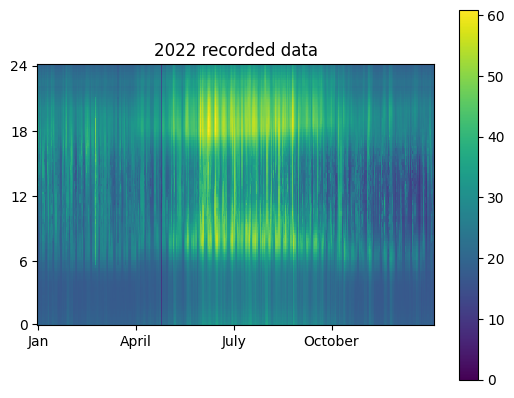

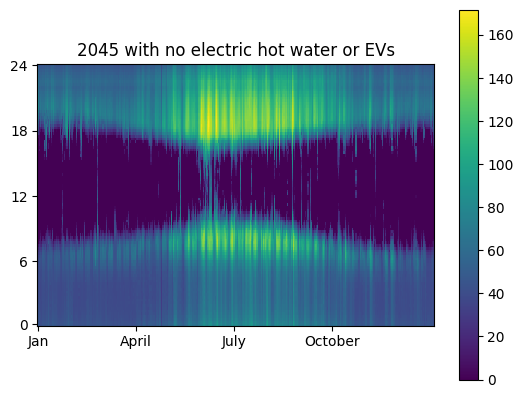

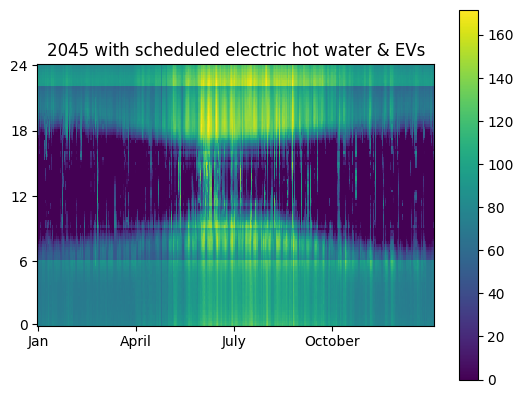

In [ ]:
# Quick plot of annual load profiles as heatmaps.

import matplotlib.pyplot as plt

min_sans = 0#many_day_df_future_sans.min().min()
max_sans = many_day_df_future_sans.max().max()

matrix = zs_df['Belconnen'].values.reshape(365,96).T[::-1]
plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=0)#min_sans, vmax=max_sans)
plt.colorbar()  # Add a colorbar to show value ranges
plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
plt.title("2022 recorded data")
plt.show()


matrix = many_day_df_future_sans[::-1]
plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=min_sans, vmax=max_sans)
plt.colorbar()  # Add a colorbar to show value ranges
plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
plt.title("2045 with no electric hot water or EVs")
plt.show()

matrix = many_day_df_future_EV[::-1]
plt.imshow(matrix, aspect=2.5, cmap='viridis', interpolation='nearest',vmin=min_sans, vmax=max_sans)
plt.colorbar()  # Add a colorbar to show value ranges
plt.xticks([0,90,2*90,3*90], ['Jan','April','July','October'])
plt.yticks([0,24,2*24,3*24,95], ['24','18','12','6','0'])
plt.title("2045 with scheduled electric hot water & EVs")
plt.show()

In [19]:
current_frac_gas = 0.45
future_frac_gas = 0.0
current_frac_heatpumps = 0.1
future_frac_heatpumps = 0.75

heat_unit = 1
current_elec_HW = (1-current_frac_gas)*((current_frac_heatpumps*heat_unit*0.3) + (1-current_frac_heatpumps*heat_unit))
future_elec_HW_per_household = ((future_frac_heatpumps*heat_unit*0.3) + (1-future_frac_heatpumps*heat_unit))
current_HW = ((plotting_df_many['Current'] - plotting_df_many['Current w/o hot water']).sum()/intervals_per_hour)
print('current_elec_HW',current_elec_HW, "\n future_elec_HW_per_household", future_elec_HW_per_household,
      '\n current_HW', current_HW)

current_elec_HW 0.5115000000000001 
 future_elec_HW_per_household 0.475 
 current_HW 16.36860394472474


In [20]:
EV = plotting_df_many['Future w hot water + EVs'] - plotting_df_many['Future w hot water']
HW = plotting_df_many['Future w hot water'] - plotting_df_many['Future w/o hot water']
plot_additions = pd.concat([HW, EV], axis=1)
plot_additions.columns=['HW', 'EV']#.reset_index()
# plot_additions.plot()

fig = go.Figure(plot_additions.plot())
# fig.update_yaxes(range = [y_min,y_max])
# if plt_min < 0:
#     fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
# fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(
    title=f"{SA_region} averaged - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="Time of day",
    yaxis_title="MW",
    legend_title="Scenarios",
)
# fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-shaped_loads.png")
fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-shaped_loads.pdf")

In [21]:
fig = go.Figure(plotting_df_many.plot())
fig.update_yaxes(range = [y_min,y_max])
if plt_min < 0:
    fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(
    title=f"{SA_region} averaged - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="Time of day",
    yaxis_title="MW",
    legend_title="Scenarios",
)
# fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average.png")
fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-average.pdf")

In [22]:
fig = go.Figure(many_day_df_future_EV[high_load_days].plot(title=''))
fig.update_yaxes(range = [y_min,y_max])
if plt_min < 0:
    fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="black")
fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(
    title=f"{SA_region} {POE} POE days - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="Time of day",
    yaxis_title="MW",
    legend_title="Days",
)

In [23]:
min_threshold_POE = many_day_df_future_EV[high_load_days].max().min()

print('Current total energy delivered = ', np.round(current_tot_energy,0), " MWh")
print('Current substation utilisation = ', np.round(100*current_tot_energy/(zs_combined_rating*24),0), " %")
print('Future total energy delivered = ', np.round(future_tot_energy,0), " MWh")
print('Future substation utilisation = ', np.round(100*future_tot_energy/(zs_combined_rating*24),0), " %")

print(f"Future threshold of {POE} POE = {np.round(min_threshold_POE,1)} MW")
print(f"Future max peak = {np.round(future_peak_load_MW,1)} MW")
print(f"Future HW demand = {np.round(future_hw_MWh_total,1)} MWh/day")
print(f"Future HW demand = {np.round((future_hw_MWh_total/future_households)*1000,1)} kWh/household/day")
print(f"Future HW demand = {np.round((future_hw_MWh_total/future_households)*250000*1000,1)} MWh for 250,000 households/day")
print(f"Future EV demand = {np.round(future_EV_MWh_day,1)} MWh/day")
print(f"Current households = {np.round((current_households)/1000,1)} k")
print(f"Future households = {np.round((future_households)/1000,1)} k")

Current total energy delivered =  142.0  MWh
Current substation utilisation =  39.0  %
Future total energy delivered =  707.0  MWh
Future substation utilisation =  194.0  %
Future threshold of 0.9 POE = 67.8 MW
Future max peak = 79.7 MW
Future HW demand = 66.1 MWh/day
Future HW demand = 2.7 kWh/household/day
Future HW demand = 673596.4 MWh for 250,000 households/day
Future EV demand = 52.8 MWh/day
Current households = 3.8 k
Future households = 24.5 k


In [24]:
nu_bins = 100
names = ['Current', 'Future - no HW or EVs', 'Future - HW, no EVs', 'Future - HW + EVs']
fig = go.Figure()
for i, data in enumerate([many_day_df_current, many_day_df_future_sans, many_day_df_future, many_day_df_future_EV]):
    occur, bins = np.histogram(data, range=(-50,y_max), bins=nu_bins, density=False)
    pdf = occur/sum(occur)
    cdf = np.cumsum(pdf) 

    fig.add_trace(go.Scatter(x=bins[1:], y=pdf, name=names[i]))

fig.add_vline(x=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(
    title=f"{SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="MW",
    yaxis_title="Frequency",
    legend_title="Scenario",
)
# fig.show()
# fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-frequency.png")

fig = go.Figure()
for i, data in enumerate([many_day_df_current, many_day_df_future_sans, many_day_df_future, many_day_df_future_EV]):
    occur, bins = np.histogram(data, range=(-50,y_max), bins=nu_bins, density=False)
    pdf = occur/sum(occur)
    cdf = np.cumsum(pdf) 

    fig.add_trace(go.Scatter(y=bins[1:], x=cdf*8760, name=names[i]))
    # fig.add_trace(go.Scatter(y=bins[1:][::-1], x=cdf*8760, name=names[i]))
fig.add_hline(y=zs_combined_rating, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(
    title=f"{SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="Hours of year",
    yaxis_title="MW",
    legend_title="Scenario",
)
fig.show()
# fig.write_image(f"{SA_region}-{solar_uptake}_solar-{EV_home_charging}_private_EV-duration.png")

In [25]:

many_day_df_future_EV.T.boxplot()
fig = px.box(many_day_df_future_EV.T)
fig.update_layout(
    title=f"{SA_region} - {solar_uptake} rooftop solar uptake, {EV_home_charging} private EV charging",
    xaxis_title="Hours of day",
    yaxis_title="MW",
    legend_title="Scenario",
)
fig.show()